In [1]:
#reading files
import os
import csv
import pandas as pd
df = pd.read_csv("/home/rk9cx/HP/honeypot_parsed_final.csv")

In [2]:
df.head()

,Unnamed: 0,timestamp,software,src_port,src_ip,session_id,dest_port,dest_ip,details
0,0,2018-08-03 17:13:49.070316+00:00,-,0,0,0,0,128.143.31.40,"Python Version 2.7.13 (default, Nov 24 2017, ..."
1,1,2018-08-03 17:13:49.070369+00:00,-,0,0,0,0,128.143.31.40,Twisted Version 18.7.0
2,2,2018-08-03 17:13:49.073059+00:00,-,0,0,0,0,128.143.31.40,Loaded output engine: jsonlog
3,3,2018-08-03 17:13:49.074273+00:00,twisted.scripts._twistd_unix.UnixAppLogger#info,0,0,0,0,128.143.31.40,twistd 18.7.0 (/home/cowrie/cowrie/cowrie-env...
4,4,2018-08-03 17:13:49.074452+00:00,twisted.scripts._twistd_unix.UnixAppLogger#info,0,0,0,0,128.143.31.40,reactor class: twisted.internet.epollreactor....


In [3]:
#importing all modules
import os
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True) #do not miss this line
from gensim import corpora, models, similarities
import warnings
warnings.filterwarnings("ignore")

In [4]:
corpus=[]
a=[]
for i in range(len(df['details'])):
        a=df['details'][i]
        corpus.append(a)

In [5]:
import gensim
import logging
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [6]:
import nltk as nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from string import punctuation

# remove common words and tokenize
list1 = ['RT','rt']
list2 = ['1', '2', '3', '4','5','6','7','8','9']
stoplist = stopwords.words('english') + list(punctuation) + list1 + list2

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

[nltk_data] Downloading package stopwords to /home/rk9cx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'hp.dict'))  # store the dictionary, for future reference
#print(dictionary)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'hp.mm'), corpus)  # store to disk, for later use

In [ ]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

In [10]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [11]:
total_topics = 5

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [17]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.113*"cd" + 0.070*"command" + 0.056*"remote" + 0.053*"&&" + 0.053*"ssh"'),
 (1,
  '0.092*"state" + 0.080*"new" + 0.063*"emfile" + 0.046*"returned" + 0.046*"changed"'),
 (2,
  '0.272*"found:" + 0.258*"command" + 0.097*"/bin/busybox" + 0.041*"rm" + 0.036*"cat"'),
 (3,
  '0.206*"cmd:" + 0.127*"/bin/busybox" + 0.035*"rm" + 0.034*"alg:" + 0.034*"alg,"'),
 (4,
  '0.093*"connection" + 0.093*"lost" + 0.091*"seconds" + 0.041*"\'none\'" + 0.040*"\'hmac-sha1\'"')]

In [19]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [18]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(115, 5)
(5, 115)


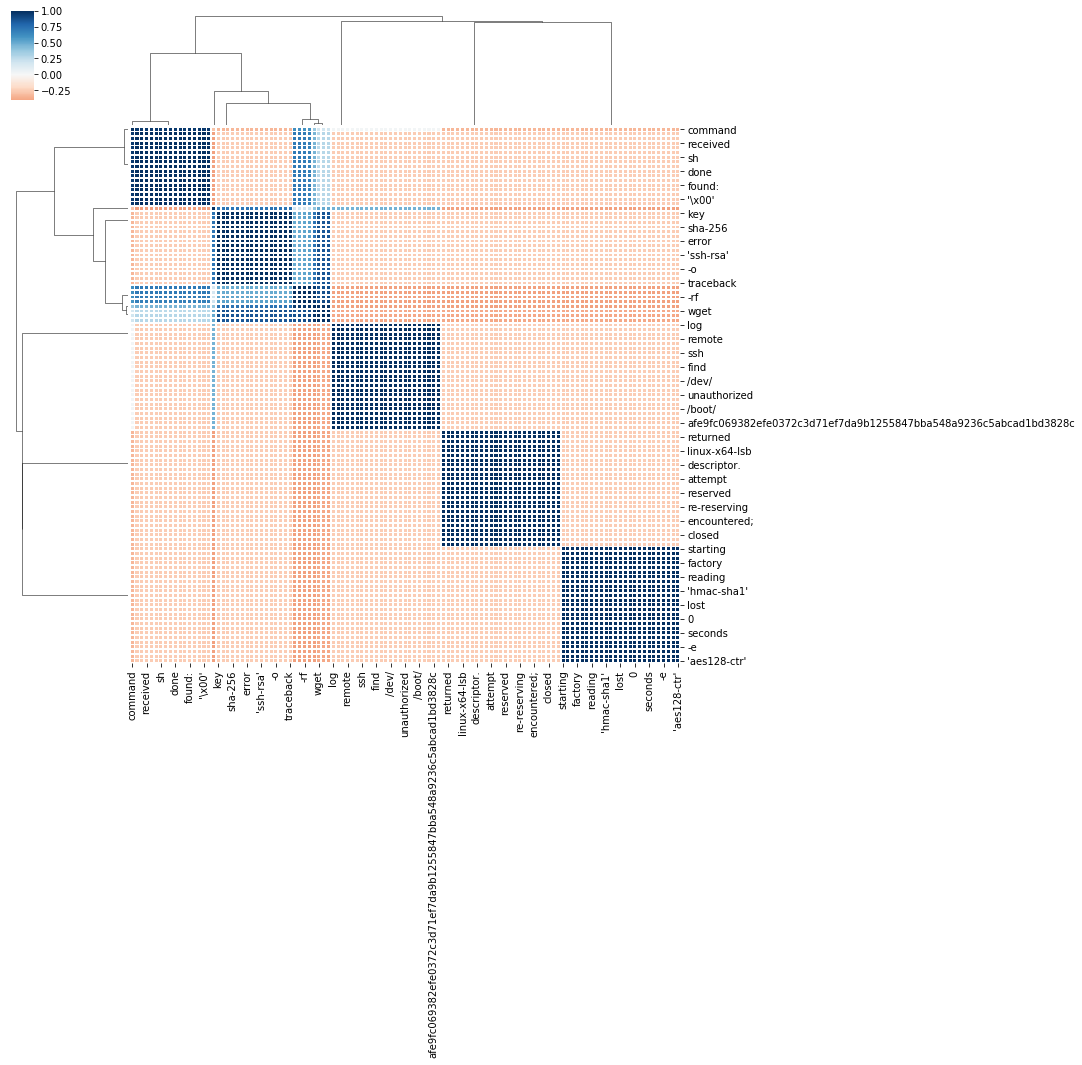

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [20]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')


In [21]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -104.434258  -52.314999       1        1  59.550877
0      139.417542   69.916260       2        1  10.274715
4      106.837036  -85.288734       3        1  10.258684
2      -13.344413 -188.769928       4        1  10.258396
1      -24.056313   83.864525       5        1   9.657335, topic_info=      Category           Freq                Term          Total  loglift  \
term                                                                        
149    Default  387854.000000                cmd:  387854.000000  30.0000   
152    Default   88167.000000              found:   88167.000000  29.0000   
151    Default  106243.000000             command  106243.000000  28.0000   
162    Default  270689.000000        /bin/busybox  270689.000000  27.0000   
178    Default   36713.000000                  cd   36713.000000  26.0000   
76     Default   30220.000000          connection   30220.000000  25.0000   
77     Default   30131.000000                lost   30131.000000  24.0000   
78     Default   29524.000000             seconds   29524.000000  23.0000   
129    Default   28166.000000               state   28166.000000  22.0000   
197    Default   79790.000000                  rm   79790.000000  21.0000   
51     Default   24402.000000                 new   24402.000000  20.0000   
76826  Default   19225.000000              emfile   19225.000000  19.0000   
53     Default   18211.000000              remote   18211.000000  18.0000   
814    Default   17287.000000                  &&   17287.000000  17.0000   
45     Default   17051.000000                 ssh   17051.000000  16.0000   
157    Default   16333.000000               can't   16333.000000  15.0000   
158    Default   16097.000000                find   16097.000000  14.0000   
159    Default   14892.000000                none   14892.000000  13.0000   
128    Default   14083.000000            returned   14083.000000  12.0000   
130    Default   14083.000000            warning:   14083.000000  11.0000   
127    Default   14083.000000             changed   14083.000000  10.0000   
60     Default   63088.000000                alg,   63088.000000   9.0000   
61     Default   63088.000000                alg:   63088.000000   8.0000   
62     Default   63088.000000                 kex   63088.000000   7.0000   
63     Default   63088.000000                 key   63088.000000   6.0000   
59     Default   62814.000000           'ssh-rsa'   62814.000000   5.0000   
150    Default   66530.000000              enable   66530.000000   4.0000   
6183   Default   13527.000000                file   13527.000000   3.0000   
76825  Default   13494.000000         descriptor.   13494.000000   2.0000   
66     Default   13118.000000              'none'   13118.000000   1.0000   
...        ...            ...                 ...            ...      ...   
129     Topic5   28166.300781               state   28166.646484   2.3374   
51      Topic5   24402.634766                 new   24402.980469   2.3374   
128     Topic5   14083.160156            returned   14083.505859   2.3374   
127     Topic5   14083.160156             changed   14083.505859   2.3374   
130     Topic5   14083.160156            warning:   14083.505859   2.3374   
6183    Topic5   13526.671875                file   13527.019531   2.3374   
50      Topic5    8275.008789         connection:    8275.354492   2.3374   
49      Topic5    8275.008789           [session:    8275.354492   2.3374   
106     Topic5    7112.036621             attempt    7112.382812   2.3374   
107     Topic5    7039.979980               login    7040.326172   2.3374   
122     Topic5    5627.729492  (128.143.31.40:23)    5628.075195   2.3374   
126     Topic5    4741.263184              failed    4741.613770   2.3374   
76826   Topic5   19223.740234              emfile   19225.939453   2.3373   
76825   T